In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 4
t = 1.0
t_prime = 0.3
mu = 0.0

# Exact part

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

## Construct the reduced Hamiltonian.

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-5.657 -5.372 -4.374 -3.901 -3.901 -3.254 -1.716 -1.716]


In [5]:
U_sweep = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

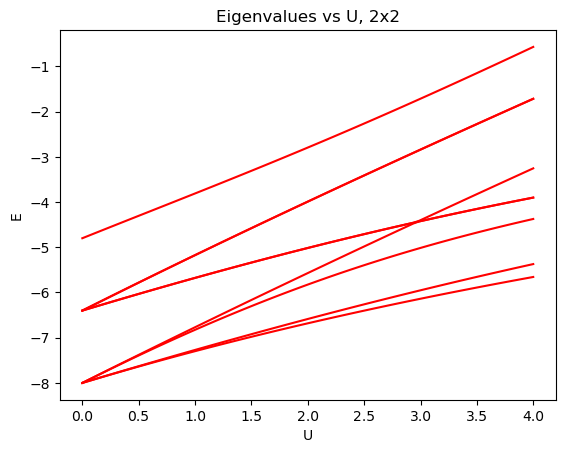

In [6]:
for band in range(9):
    plt.plot(U_sweep, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:3])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4, 4, 1]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [12]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

# Eigenbranches

In [23]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 5000
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [24]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

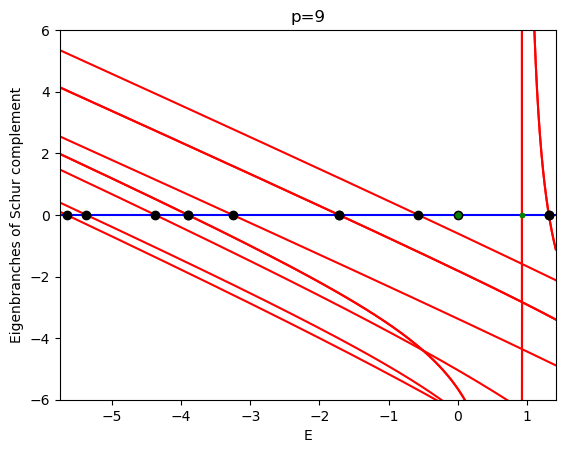

In [26]:
plt.title('p=9')
plt.xlabel('E')
plt.ylabel('Eigenbranches of Schur complement')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-6, 6)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

In [16]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[15] + 0.1]
N_plot = 5000
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [17]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

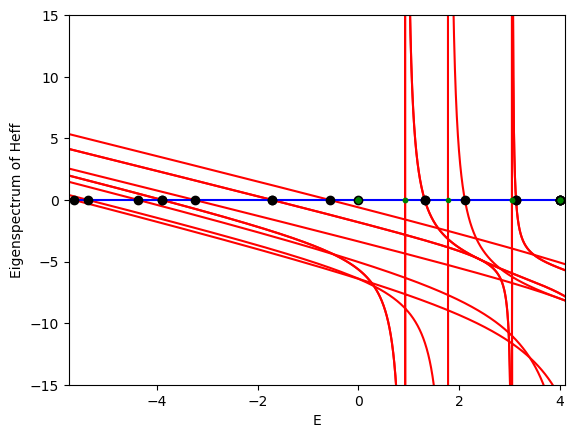

In [18]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-15, 15)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

In [19]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[25] + 0.1]
N_plot = 5000
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [20]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

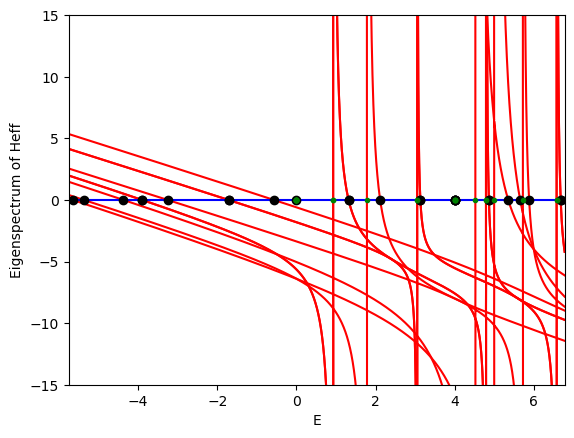

In [21]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-15, 15)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()